# Auditory Fear Conditioning NWB Tutorial

This tutorial demonstrates how to load and explore an NWB file containing only behavioral data from the auditory fear conditioning experiment, part of the [Rat Behavioural Phenotyping Pipeline Methodologies](https://sidb.org.uk/facilities/rat-behavioural-phenotyping-pipeline/).

Contents:

- [Reading NWBFile locally](#read-nwb)
- [Access Subject Metadata](#access-subject)
- [Access Devices Metadata](#access-devices)
- [Access Behavioral Videos](#access-behavior)
- [Access Trials](#access-trials)



# Reading an NWB file locally<a id="read-nwb"></a>


This section demonstrates how to read an NWB file using `pynwb`.

Based on the [NWB File Basics](https://pynwb.readthedocs.io/en/stable/tutorials/general/plot_file.html#sphx-glr-tutorials-general-plot-file-py) tutorial from [PyNWB](https://pynwb.readthedocs.io/en/stable/#).

An [NWBFile](https://pynwb.readthedocs.io/en/stable/pynwb.file.html#pynwb.file.NWBFile) represents a single session of an experiment. Each NWBFile must have a `session description`, `identifier`, and `session start time`.

Reading is carried out using the [NWBHDF5IO](https://pynwb.readthedocs.io/en/stable/pynwb.html#pynwb.NWBHDF5IO) class. To read the NWB file use the read mode ("r") to retrieve an NWBFile object.

In [1]:
from pynwb import NWBHDF5IO
from pathlib import Path

# Define the path to the NWB file
directory = Path("D:/kind_lab_conversion_nwb/auditory_fear_conditioning")
session_id = "AFC_1_HabD1"
subject_id = "408_Arid1b(3)"
nwbfile_path = directory / f"sub-{subject_id}_ses-{session_id}.nwb"
io = NWBHDF5IO(path=nwbfile_path, load_namespaces=True)
nwbfile = io.read()

In [2]:
print(nwbfile.experiment_description)

This experiment is part of the Rat Behavioural Phenotyping Pipeline Methodologies https://sidb.org.uk/facilities/rat-behavioural-phenotyping-pipeline/.
As an initial effort to characterize the rat lines, these models are being behaviorally phenotyped at SIDB.
Rat models are phenotyped according to a rigorous pipeline that assesses behaviours relevant to autism with intellectual disability, such as social and motor skills, and learning and sensory processing.
Different cohorts of rats are run through different subsets of tasks to overcome potential order effects on behaviours and to limit the number of tasks each animal is put through.
This experiment investigated auditory fear conditioning in different rat models
(Arid1b: https://rgd.mcw.edu/rgdweb/report/strain/main.html?id=14394518,
Grin2b: https://rgd.mcw.edu/rgdweb/report/strain/main.html?id=14394515,
Scn2a: https://rgd.mcw.edu/rgdweb/report/strain/main.html?id=25394530).
The experimenter was blind to genotype throughout the experi

In [3]:
print(nwbfile.session_description)

Experimental Day 1. Habituation to context A.
20 min exposure to context A, no tones or shocks.



Importantly, the `session start time` is the reference time for all timestamps in the file. For instance, an event with a timestamp of 0 in the file means the event occurred exactly at the session start time.

The `session_start_time` is extracted from the Freeze_Log.xls table.

In [4]:
print(nwbfile.session_start_time)

2022-12-12 11:12:00+00:00


# Access Subject Metadata <a name="access-subject"></a>

This section demonstrates how to access the [Subject](https://pynwb.readthedocs.io/en/stable/pynwb.file.html#pynwb.file.Subject) field in an NWB file.

The [Subject](https://pynwb.readthedocs.io/en/stable/pynwb.file.html#pynwb.file.Subject) field can be accessed as `nwbfile.subject`.


In [5]:
nwbfile.subject

subject pynwb.file.Subject at 0x1384206802800
Fields:
  age__reference: birth
  date_of_birth: 2022-09-02 00:00:00+02:00
  sex: M
  species: Rattus norvegicus
  subject_id: 408_Arid1b(3)

# Access Devices Metadata <a name="access-devices"></a>

This section demonstrates how to access the [Device](https://pynwb.readthedocs.io/en/stable/pynwb.device.html#module-pynwb.device) field in an NWB file.

The [Device](https://pynwb.readthedocs.io/en/stable/pynwb.device.html#module-pynwb.device) field can be accessed as `nwbfile.devices`.

In [6]:
nwbfile.devices["BehavioralCamera"]

BehavioralCamera pynwb.device.Device at 0x1384206802320
Fields:
  description: CCTV camera mounted on ceiling above chambers for behavioral recording
  manufacturer: Example Manufacturer

In [7]:
nwbfile.devices["ChamberA"] # ChamberB

ChamberA pynwb.device.Device at 0x1384206802656
Fields:
  description: Coulbourn Fear conditioning chamber - Context A
Smooth plastic flooring, curved black/white striped plastic mat on walls,
black/white tiles, mint toothpaste odor cue

  manufacturer: Coulbourn, Harvard Apparatus

In [8]:
nwbfile.devices["SoundAttenuatingChamber"]

SoundAttenuatingChamber pynwb.device.Device at 0x1384206802752
Fields:
  description: Chamber housing the fear conditioning chambers for sound isolation
  manufacturer: Coulbourn, Harvard Apparatus

# Access Behavioral Video <a name="access-behavior"></a>

The behavioral video is stored as an external `ImageSeries` in the NWB file.

In [9]:
video = nwbfile.acquisition["BehavioralVideo"]
video

Data type,uint8
Shape,"(0, 0, 0)"
Array size,0.00 bytes
Chunk shape,None
Compression,None
Compression opts,None
Compression ratio,undefined
Data type,object
Shape,"(1,)"
Array size,8.00 bytes
Chunk shape,None


The video filepath:

In [10]:
video.external_file[0]

'/Users/weian/data/Auditory Fear Conditioning/Arid1b/Arid1b(3)_AFC/1_HabD1/Box3_Arid1b(3)_HabD1_408.avi'

The metadata of the device used to record the behavioral video:


In [11]:
video.device

BehavioralCamera pynwb.device.Device at 0x1384206802320
Fields:
  description: CCTV camera mounted on ceiling above chambers for behavioral recording
  manufacturer: Example Manufacturer

# Access Trials <a name="access-trials"></a>

The `nwbfile.trials` contains periods of freezing behavior, as detected and scored by the FreezeFrame 5 software.  
Each row in the table corresponds to a single freezing event, with columns for the start and stop times (relative to session start), and additional columns such as duration or manual scoring.

You can convert the trials table to a `pandas.DataFrame` for easier exploration:


In [12]:
trials = nwbfile.trials.to_dataframe()
trials

,start_time,stop_time,percentage_of_time_spent_freezing,threshold,bout_duration,protocol
id,,,,,,
0,0.0,120.0,0.00,360.00,3.0,tone recall/extinction 5Khz tone
1,120.0,150.0,34.67,360.00,3.0,tone recall/extinction 5Khz tone
2,150.0,180.0,37.05,360.00,3.0,tone recall/extinction 5Khz tone
3,180.0,210.0,63.56,360.00,3.0,tone recall/extinction 5Khz tone
4,210.0,240.0,64.71,360.00,3.0,tone recall/extinction 5Khz tone
5,240.0,270.0,50.67,360.00,3.0,tone recall/extinction 5Khz tone
6,270.0,300.0,59.82,360.00,3.0,tone recall/extinction 5Khz tone
7,300.0,330.0,75.89,360.00,3.0,tone recall/extinction 5Khz tone
8,330.0,360.0,42.86,360.00,3.0,tone recall/extinction 5Khz tone


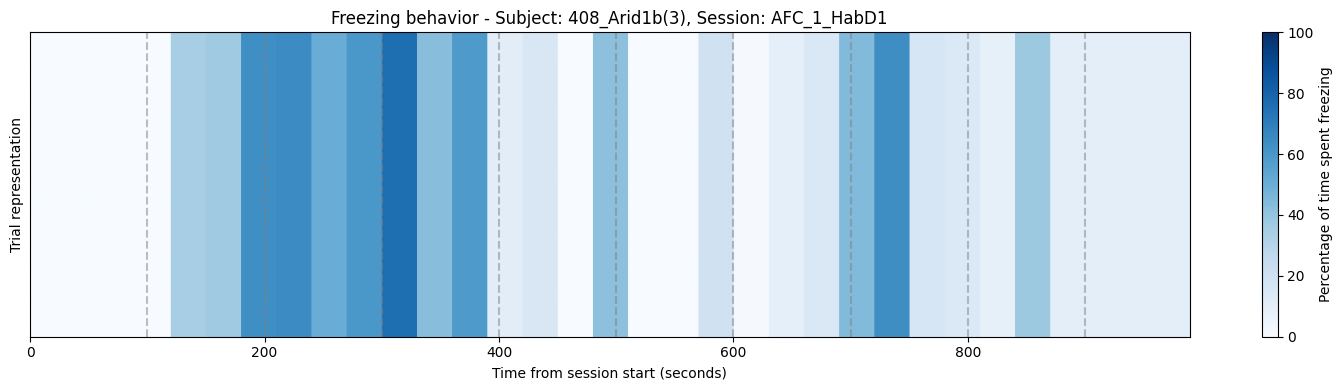

In [13]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Calculate total experiment duration
experiment_duration = int(trials['stop_time'].max())

# Create an image array to represent the trials
image_width = experiment_duration
image_height = 100
image = np.zeros((image_height, image_width, 4))  # RGBA

# Define colormap for percentage of freezing (cool colors)
cmap = plt.cm.Blues

# Fill in the image with trial data
for _, row in trials.iterrows():
    start = int(round(row['start_time']))
    stop = int(round(row['stop_time']))
    width = stop - start
    
    # Get color based on percentage of time spent freezing
    freeze_pct = row['percentage_of_time_spent_freezing']
    color_intensity = freeze_pct / 100.0 if freeze_pct > 0 else 0
    color = cmap(color_intensity)
    
    # Fill the column with the appropriate color
    for x in range(start, stop):
        if x < image_width:
            image[:, x] = color

# Create a figure and display the image
fig, ax = plt.subplots(figsize=(15, 4))
ax.imshow(image, aspect='auto')

# Add color bar for reference
norm = mcolors.Normalize(vmin=0, vmax=100)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, label='Percentage of time spent freezing')

# Add labels and title
ax.set_title(f'Freezing behavior - Subject: {subject_id}, Session: {session_id}')
ax.set_xlabel('Time from session start (seconds)')
ax.set_ylabel('Trial representation')

# Remove y-axis ticks as they don't represent anything specific
ax.set_yticks([])

# Add some markers for reference every 100 seconds
for t in range(0, experiment_duration, 100):
    ax.axvline(x=t, color='gray', linestyle='--', alpha=0.5)
    
plt.tight_layout()
plt.show()